In [28]:
import numpy as np
import scipy.stats as st
import pandas as pd
from pandas.api import types as ptypes
import matplotlib.pyplot as plt

df = pd.read_csv("../Data/housing.csv")
display(df.head())
is_num = df.dtypes.apply(ptypes.is_numeric_dtype)
numeric = is_num.sum()
categorical = len(is_num) - numeric

print(f'Antal kolumner: {df.columns.size} \nAntal numeriska kolumner: {numeric} \nAntal kategoriska kolumner: {categorical}')


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Antal kolumner: 10 
Antal numeriska kolumner: 9 
Antal kategoriska kolumner: 1


Datasetet består av 10 kolumner, varav 9 är numeriska och 1 är kategorisk, där den kategoriska är ocean_proximity.  

Efter utforskning av datasetet väljer i mitt första exempel jag median_house_value som min responsvariabel Y och median_income som min obundna variabel X.

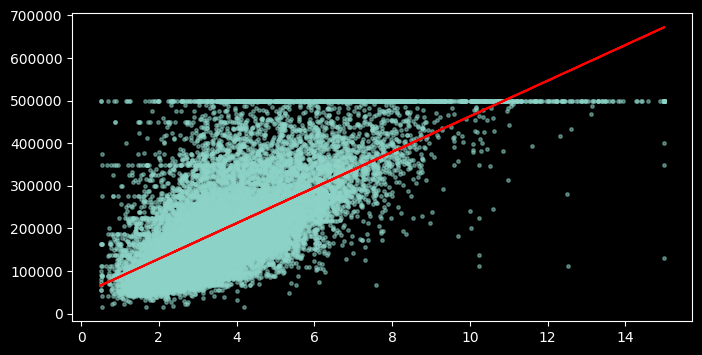

In [29]:
from Linear_regression import LinearRegression

X = df[['median_income']]
y = df['median_house_value']

model = LinearRegression()
model.fit(X, y)
beta0, beta1 = model.b
Y = beta0 + X * beta1

plt.figure(figsize=(8,4))
plt.scatter(X, y, s= 6, alpha = 0.5)
plt.plot(X, Y, color = 'red')


In [30]:
print("SSE:", model.SSE())
print("MSE:", model.MSE())
print("RMSE:", model.RMSE())
print("std:", model.residual_std())

SSE: 144713469420465.44
MSE: 7011311502.929527
RMSE: 83733.57452616918
std: 83737.63168025379


In [ ]:
model.fit(X, y)
F, p = model.significance()
print(f"F = {F:.4f}, p = {p:.4e}")

alpha = 0.05
if p < alpha:
    print("Modellen är signifikant: förkasta H0 (minst en koefficient ≠ 0).")
else:
    print("Ingen signifikans: kan inte förkasta H0 (inga bevis att någon av koefficienterna ≠ 0).")

F = 18556.5716, p = 0.0000e+00
Modellen är signifikant: förkasta H0 (minst en koefficient ≠ 0).


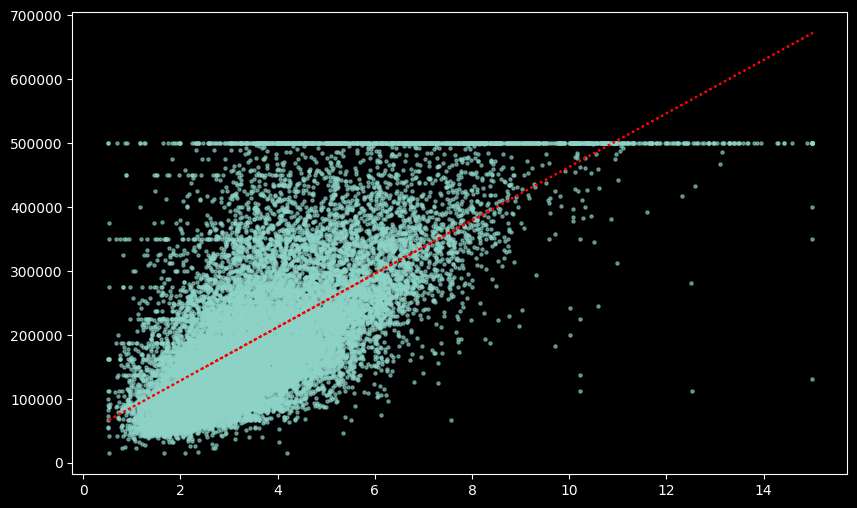

In [32]:
plt.style.use('dark_background')
plt.figure(figsize=(10,6))

beta0, beta1 = model.b
b = beta0 + X * beta1
plt.scatter(X, y, alpha = 0.6, s= 5)
plt.plot(X, b, color = 'red', linestyle = ':')

